# standard notebook for copying

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [3]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle

#import mapfxn as mf
#reload(mf)

plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

## get out lat and lon, tmask

In [4]:
tmesh = nc.Dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmask = tmesh['tmaskutil'][0,:,:] 
print(np.shape(tmask))
print('SO south of -50 is 0:37, SO south of -30 is 0:50')
lats = tmesh['nav_lat'][:,0]
lons = tmesh['nav_lon'][0,:]

(149, 182)
SO south of -50 is 0:37, SO south of -30 is 0:50


### do a pcolormesh - this one looks wonky but syntax is fine

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


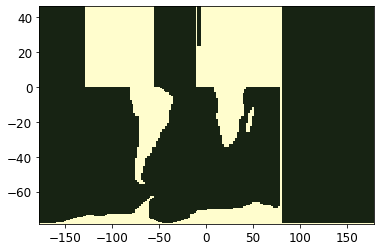

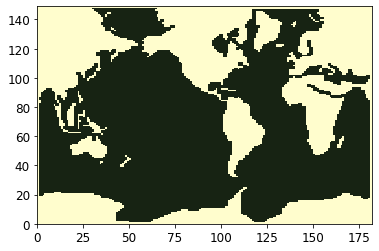

In [5]:
plt.figure()
plt.pcolormesh(lons, lats, tmask, vmin = 0, vmax = 1, cmap = cm.speed)

plt.figure()
plt.pcolormesh(tmask, vmin = 0, vmax = 1, cmap = cm.speed)

### get various tmesh things

In [6]:
tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]
#size of cells in m2


### 4D mask
tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
deptat = (tmesh['gdept_1d'][0,:])
tmask = (tmesh['tmask'])
depth4d = np.zeros([12,31,149,182])
tmask4d = np.zeros([12,31,149,182])
#broadcast m depth across the whole array to get an array of "depth of cell here in the grid" that is the same shape as a given variable
for i in range(0,31):
    depth4d[:,i,:,:] = deptat[i].values

for i in range(0,12):
    tmask4d[i,:,:,:] = tmask
depth4dm = depth4d *tmask4d 

## get means and percentiles with masks and nans

In [7]:
#get 2d array
def weighted_percentile(data, weights, perc):
    """
    perc : percentile in [0-1]!
    """
    data = np.ravel(data)
    weights = np.ravel(weights)
    ix = np.argsort(data)
    data = data[ix] # sort data
    weights = weights[ix] # sort weights
    cdf = (np.cumsum(weights) - 0.5 * weights) / np.sum(weights) # 'like' a CDF function
    return np.interp(perc, cdf, data)

run = 'LIGD'
z = xr.open_dataset(f'/gpfs/home/e415/scratch/TOM10_CL_{run}/{run}_dia3d_1998_2010_ave.nc')
ppt_sam = (z['PPT'][0,0,:,:].values)

#get weights
tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]

#get weighted percentile
p95 = weighted_percentile(ppt_sam, tmesh['csize'], 0.95)
print(p95)

#get mean
ma = np.ma.MaskedArray(ppt_sam, mask=np.isnan(ppt_sam))
q = np.ma.average(ma, weights=tmesh['csize'])
print(q)

1.4918596958752192e-08
4.299022858926132e-09


## subplots

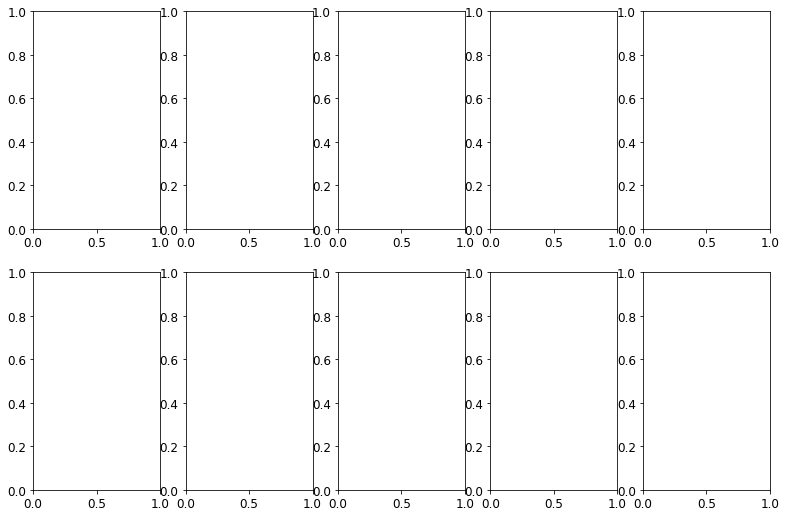

In [8]:

fact = 1.1
fig, axs = plt.subplots(2,5, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()




## latitude bands


In [9]:
bounds = np.array([0,7,16,22,28,32,37,40,44,47,50])
bounds = np.array([0,16,28,37,44,50])
starts = np.zeros([5]); ends = np.zeros([5])
print('making histograms of summer and winter wind speed for the following latitude bands:')
for i in range(0,len(bounds)-1):
    s= np.format_float_positional(tmesh['nav_lat'][bounds[i],0].values, precision=1)
    e= np.format_float_positional(tmesh['nav_lat'][bounds[i+1],0].values, precision=1)
    bs = bounds[i]
    be = bounds[i+1]
    print(f'band {i}, {(s)} to {e}, index {bs} to {be}')
    starts[i] = s
    ends[i] = e
     
print(starts)
print(ends)

making histograms of summer and winter wind speed for the following latitude bands:
band 0, -78.2 to -69.5, index 0 to 16
band 1, -69.5 to -59.3, index 16 to 28
band 2, -59.3 to -48.8, index 28 to 37
band 3, -48.8 to -38.7, index 37 to 44
band 4, -38.7 to -28.7, index 44 to 50
[-78.2 -69.5 -59.3 -48.8 -38.7]
[-69.5 -59.3 -48.8 -38.7 -28.7]


## 

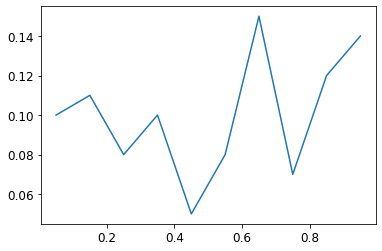

In [13]:
tdat = np.random.rand(100)
nbins = 10
start = 0
end = 1


def custhist(tdat, nbins, start, end, tweights = None):
    #bins = 25
    hist_met_vflx, bins = np.histogram(np.ravel(tdat), bins=nbins,\
                                 range = [start, end], weights=tweights)

    bin_cent = bins + (bins[1]-bins[0])/2
    tot_count = np.sum(hist_met_vflx)

    
    binsback = bins
    bin_cent = bin_cent[0:nbins]
    histback = hist_met_vflx/tot_count
    
    return binsback, bin_cent, histback

nsback, bin_cent, histback = custhist(tdat, nbins, start, end)
plt.plot(bin_cent,histback)